# Importing libraries

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# !pip install yellowbrick
from yellowbrick.classifier.rocauc import roc_auc
import joblib
import matplotlib.pyplot as plt
# sns.set(font_scale=1.3)
# nltk.download('omw-1.4')

# Read cleaned data

In [2]:
final_df=pd.read_csv('FinalData.csv')

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87097 entries, 0 to 87096
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     87092 non-null  object
 1   Emotion  87097 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [4]:
final_df.isna().sum()

Text       5
Emotion    0
dtype: int64

In [5]:
# em=final_df.loc[final_df.isna().any(axis=1)]

In [6]:
# em

In [7]:
final_df=final_df.dropna()

In [8]:
final_df.Emotion.value_counts()

sad        16186
happy      15854
angry      14359
fear       13996
neutral    13699
disgust    12998
Name: Emotion, dtype: int64

In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87092 entries, 0 to 87096
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     87092 non-null  object
 1   Emotion  87092 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


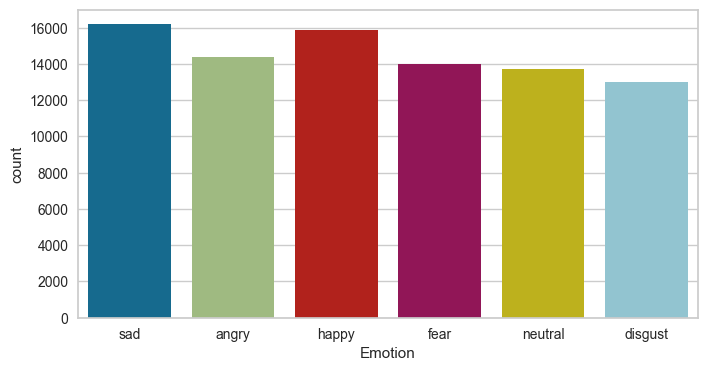

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=final_df);

# Split and training

In [11]:
label_map = {
    'sad': 0,
    'angry': 1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'disgust':5
}

In [12]:
final_df['Emotion'] = final_df['Emotion'].map(label_map)

'sad': 0,
    'angry': 1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'disgust':5

In [13]:
x_train,x_test,y_train,y_test=train_test_split(final_df['Text'],final_df['Emotion'],test_size=0.20,shuffle=True,random_state=42)

In [14]:
x_train.to_csv('x_train.csv',index=False)
y_train.to_csv('y_train.csv',index=False)
x_test.to_csv('x_test.csv',index=False)
y_test.to_csv('y_test.csv',index=False)

In [15]:
# x_train=pd.read_csv('x_train.csv').squeeze()
# y_train=pd.read_csv('y_train.csv').squeeze()
# x_test=pd.read_csv('x_test.csv').squeeze()
# y_test=pd.read_csv('y_test.csv').squeeze()

In [16]:
type(final_df['Text'])

pandas.core.series.Series

In [17]:
def train_model(model, data, targets, x_test, y_test):
    text_clf = Pipeline([('vect', TfidfVectorizer()),
                        ('clf', model)])

    text_clf.fit(data, targets)
    roc_auc_score = roc_auc(text_clf, 
                            data, 
                            targets,
                            X_test=x_test, y_test=y_test,
                            classes=['0', '1', '2', '3', '4','5']
                            )
#     print(roc_auc_score)
    return text_clf,roc_auc_score


In [19]:
models = [('Naive_Bayes', MultinomialNB()),
         ('LogReg',LogisticRegression(random_state=0,multi_class="multinomial", solver="lbfgs",max_iter=800)),
          ('Random_Forest', RandomForestClassifier(random_state = 0)),
         ('SVM',SVC(kernel='sigmoid',random_state = 0,probability=True))]

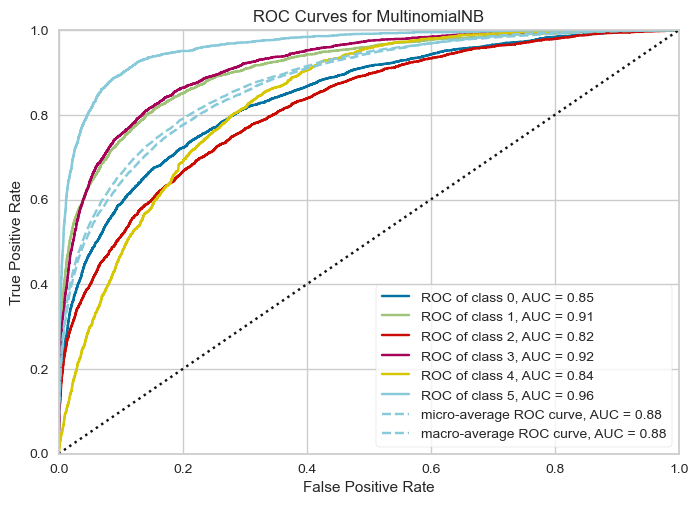

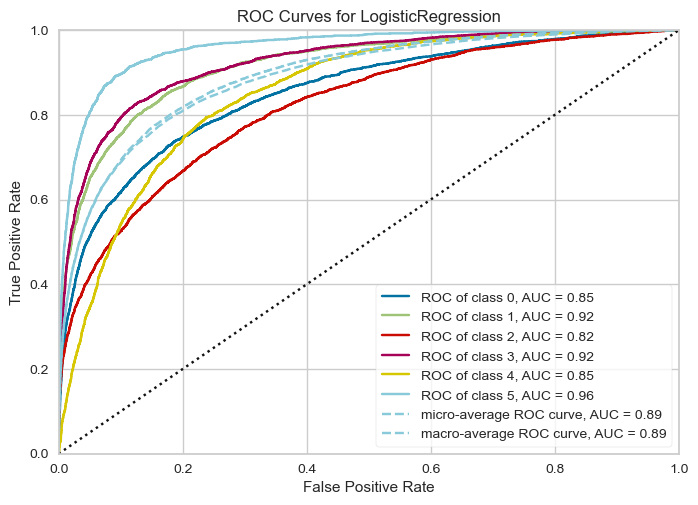

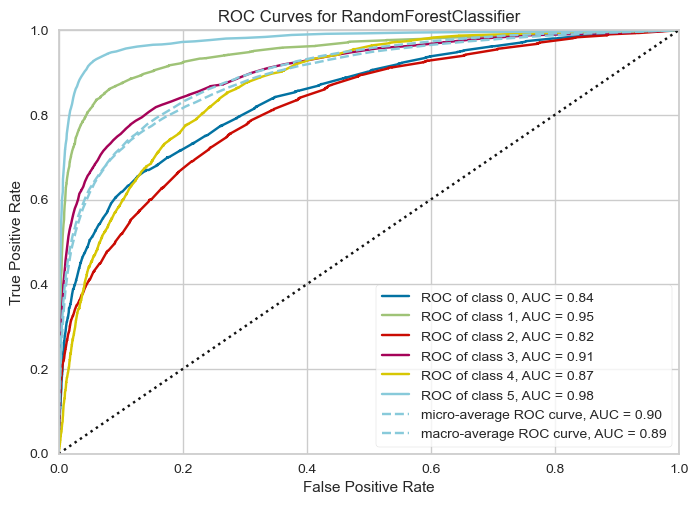

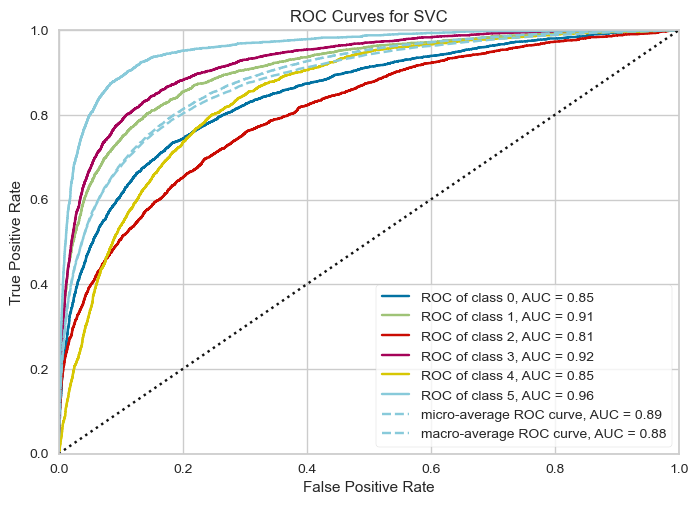

In [51]:
for name, model in models:
    model,roc=train_model(model, x_train, y_train,x_test,y_test)
    filename = name+'.sav'
    joblib.dump(model,filename)

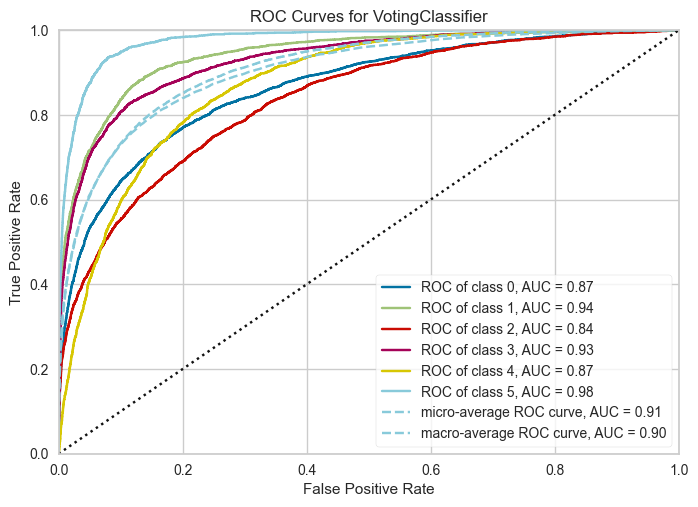

In [22]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=models,voting ='soft')
ensemble,roc=train_model(ensemble, x_train, y_train,x_test,y_test)

In [23]:
filename = 'saved_models//ensemble.sav'
joblib.dump(ensemble,filename)

['saved_models//ensemble.sav']